In [80]:
import json, pycm, itertools, pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from scipy.stats import spearmanr

In [81]:
experiments = json.load(open('samples_per_query_study_model-agnostic.json', 'r'))

In [82]:
samples_per_query_metrics = {}
for experiment in experiments:
    df1 = pd.DataFrame.from_records(experiment["data"])
    df1a = df1[["label", "p(Hallucination)"]].rename(columns={'label': 'h_label', 'p(Hallucination)': 'h_p'})
    df2 = pd.DataFrame.from_records(experiment["predictions"])
    df2a = df2[["label", "p(Hallucination)"]].rename(columns={'label': 's_label', 'p(Hallucination)': 's_p'})
    df3 = pd.concat([df1a, df2a], axis=1)
    cm = pycm.ConfusionMatrix(df3["h_label"].tolist(), df3["s_label"].tolist(), digit=2, classes=[ 'Hallucination', 'Not Hallucination' ])
    rho, _ = spearmanr(df3['h_p'], df3['s_p'])
    samples_per_query = str(experiment["config"]["samples"])
    if not samples_per_query in samples_per_query_metrics:
        samples_per_query_metrics[samples_per_query] = { "accuracy": [], "rho": [], "kappa": [] }
    samples_per_query_metrics[samples_per_query]["accuracy"].append(cm.ACC['Hallucination'])
    samples_per_query_metrics[samples_per_query]["rho"].append(rho)
    samples_per_query_metrics[samples_per_query]["kappa"].append(cm.Kappa)

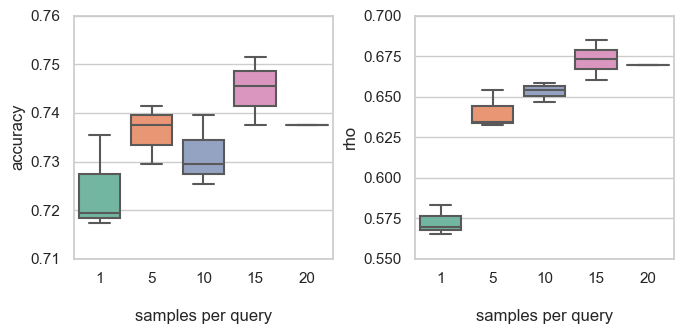

In [83]:
flattened_metrics = []

for samples_per_query, metrics in samples_per_query_metrics.items():
    for metric_name, values in metrics.items():
        for value in values:
            flattened_metrics.append({"Samples per query": samples_per_query, "Metric": metric_name, "Value": value})

df_long = pd.DataFrame.from_records(flattened_metrics)
df_long2 = df_long[df_long["Metric"] == "accuracy"]
df_long3 = df_long[df_long["Metric"] == "rho"]
df_long4 = df_long[df_long["Metric"] == "kappa"]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 3.5))
# fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

sns.set_theme(style="whitegrid")
sns.boxplot(x='Samples per query', y='Value', data=df_long2, palette="Set2", ax=axes[0])
axes[0].set_xlabel('\nsamples per query')
axes[0].set_ylabel('accuracy')
axes[0].set_ylim(0.71, 0.76)

sns.set_theme(style="whitegrid")
sns.boxplot(x='Samples per query', y='Value', data=df_long3, palette="Set2", ax=axes[1])
axes[1].set_xlabel('\nsamples per query')
axes[1].set_ylabel('rho')
axes[1].set_ylim(0.55, 0.7)

# sns.set_theme(style="whitegrid")
# sns.boxplot(x='Samples per query', y='Value', data=df_long4, palette="Set2", ax=axes[2])
# axes[2].set_xlabel('\nsamples per query')
# axes[2].set_ylabel('kappa')
# axes[2].set_ylim(0.4, 0.6)

plt.tight_layout()
plt.show()